In [33]:
import os
import math
import numpy as np
import pandas as pd
from collections import defaultdict

# Image and Plotting Libraries
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation
import matplotlib.patheffects as path_effects
from matplotlib.patheffects import withStroke
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties
from numpy.polynomial.polynomial import Polynomial
import seaborn as sns
from PIL import Image

# Scikit-learn Libraries
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# SciPy Libraries
from scipy.stats import gaussian_kde, zscore
from scipy.ndimage import distance_transform_edt
from scipy import ndimage
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

# Skimage Libraries
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import label
from skimage.filters import sobel

In [5]:
#LOAD DATA

#Read the Excel file into a DataFrame
file_path = 'Plate info 0923.csv'
df = pd.read_csv(file_path, header='infer', index_col=0)

# Function to append numbers to duplicate index values to make them unique
def make_unique_index(s):
    # Dictionary to hold counts of occurrences
    d = {}
    def count_and_append(val):
        d[val] = d.get(val, 0) + 1
        return f"{val}_{d[val]}" if d[val] > 1 else val
    return s.map(count_and_append)

# Update the index to ensure uniqueness
df.index = make_unique_index(df.index)

df.shape

(3297, 203)

In [6]:
#DATA CLEANING

#delete first bin due to edge effects on nuclei detection
columns_to_delete = [2, 52, 102, 152]

# Delete the specified columns
df = df.drop(df.columns[columns_to_delete], axis=1)

#delete high cell count errors due to error in edge detection
df = df[df['total cells'] < 1492]


df.shape

(3259, 199)

In [7]:
#DATA IMPUTATION DUE TO UNDESIZED COLONIES

#replace 0s with the average of the 3 values before it

# Count the number of 0 values in the entire DataFrame before replacement
initial_zero_count = (df == 0).sum().sum()

# Function to replace values within the specified range for density columns (iloc[2:51])
def replace_density_values(row):
    for col_idx in range(2, 51):
        if row[col_idx] <= 0.0001:
            # Calculate the average of the preceding 3 values (or less if not available)
            avg = row[max(col_idx - 3, 0):col_idx].mean()
            row[col_idx] = avg
    return row

# Function to replace values within the specified range for other columns (iloc[51:])
def replace_other_values(row):
    for col_idx in range(51, 198):  # Corrected the range
        if row[col_idx] < 250:
            # Calculate the average of the preceding 3 values (or less if not available)
            avg = row[max(col_idx - 3, 51):col_idx].mean()
            row[col_idx] = avg
    return row

# Apply the replacement functions to each row in the DataFrame
df = df.apply(replace_density_values, axis=1)
df = df.apply(replace_other_values, axis=1)

In [8]:
#DEFINING DATA RANGES AND VARIABLES

# Define the iloc indices for each range
cell_count_range = df.iloc[:, 0:1]
density_range = df.iloc[:, 2:51]  
GATA_range = df.iloc[:, 51:100]   
BRA_range = df.iloc[:, 100:149]    
SOX_range = df.iloc[:, 149:198]    

# Define the plate values
plate_values = df['plate'].unique()

# Initialize dictionaries to store median and mean values
median_values = {}
mean_values = {}
std_values = {}
mad_values = {}

# Iterate through plate values and ranges
for plate in plate_values:
    for range_name, range_columns in zip(['cell_count', 'density', 'GATA', 'BRA', 'SOX'], [cell_count_range, density_range, GATA_range, BRA_range, SOX_range]):
        # Filter DataFrame by plate and selected range
        filtered_df = df[df['plate'] == plate][range_columns.columns]
        
        # Calculate median for the selected range
        median_value = np.median(filtered_df.values.flatten())
        median_values[f'{plate}_{range_name}_median'] = median_value
        
        # Calculate mean for the selected range
        mean_value = np.mean(filtered_df.values.flatten())
        mean_values[f'{plate}_{range_name}_mean'] = mean_value
        
        # Calculate standard deviation for the selected range
        std_value = np.std(filtered_df.values.flatten())
        std_values[f'{plate}_{range_name}_std'] = std_value
        
        # Calculate the MAD (Median Absolute Deviation)
        mad_value = np.median(np.abs(filtered_df.values.flatten() - median_values[f'{plate}_{range_name}_median']))
        mad_values[f'{plate}_{range_name}_mad'] = mad_value

In [9]:
#NORMALIZATION - SUBTRACT MEAN then ROBUST SCALE

# Define a dictionary to map range names to range columns
range_dict = {'density': density_range, 'GATA': GATA_range, 'BRA': BRA_range, 'SOX': SOX_range}

# Create a new DataFrame to store the Z-scored values
z_scored_df = df.copy()  # Start with a copy of the original DataFrame

# Iterate through plate values and ranges
for plate in plate_values:
    for range_name, range_columns in zip(['density','GATA', 'BRA', 'SOX'], [density_range, GATA_range, BRA_range, SOX_range]):
        # Filter DataFrame by plate and selected range
        filtered_df = z_scored_df[z_scored_df['plate'] == plate][range_columns.columns]
        
        # Calculate Z-scores based on the mean
        z_scores = (filtered_df - mean_values[f'{plate}_{range_name}_mean']) 
        
        # Calculate the 25th and 75th percentiles
        q25 = z_scores.quantile(0.25).min()
        q75 = z_scores.quantile(0.75).max()
        
        # Scaling based on the 25th and 75th percentiles
        normalized_values = (z_scores - q25) / (q75 - q25)
        
        # Assign the scaled values to z_scored_df for the corresponding plate and range
        z_scored_df.loc[z_scored_df['plate'] == plate, range_columns.columns] = normalized_values

In [10]:
#REMOVE PLATES WITH IMPROPER STAINING

# remove rows where 'plate' values are A, C, or D but keep CHIR
z_scored_df = z_scored_df[(~z_scored_df['plate'].isin(['A', 'C', 'D'])) | z_scored_df.index.str.contains("CHIR")]

z_scored_df.shape

(2025, 199)

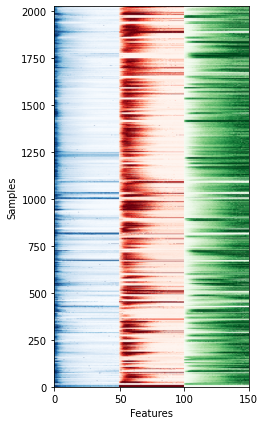

In [11]:
#FIG 1E 

# Define the correct ranges
GATA_range1 = z_scored_df.iloc[:, 51:100]
BRA_range1 = z_scored_df.iloc[:, 100:149]
SOX_range1 = z_scored_df.iloc[:, 149:198]

# Normalize each range to the 75th and 25th percentiles
def normalize_range(data):
    lower = data.quantile(0.25).min()
    upper = data.quantile(0.75).max()
    return (data - lower) / (upper - lower)

GATA_matrix = normalize_range(GATA_range1)
BRA_matrix = normalize_range(BRA_range1)
SOX_matrix = normalize_range(SOX_range1)

# Clip values to be between 0 and 1 after normalization
GATA_matrix = GATA_matrix.clip(0, 1)
BRA_matrix = BRA_matrix.clip(0, 1)
SOX_matrix = SOX_matrix.clip(0, 1)

# Apply colormaps
GATA_colors = plt.cm.Blues(GATA_matrix)
BRA_colors = plt.cm.Reds(BRA_matrix)
SOX_colors = plt.cm.Greens(SOX_matrix)

# Combine the color matrices along the features axis
combined_colors = np.concatenate((GATA_colors, BRA_colors, SOX_colors), axis=1)

# Plot the image
fig, ax = plt.subplots(figsize=(3.5, 7))
ax.imshow(combined_colors, aspect='auto')
ax.set_xlabel('Features')
ax.set_ylabel('Samples')

# Reverse the y-axis so that sample 0 is at the bottom
ax.invert_yaxis()

# Set x-ticks
ax.set_xticks([0, 50, 98, 147])
ax.set_xticklabels(['0', '50', '100', '150'])

# Save the figure
plt.savefig('High dimensional data viz.png', dpi=300, bbox_inches='tight')

plt.show()

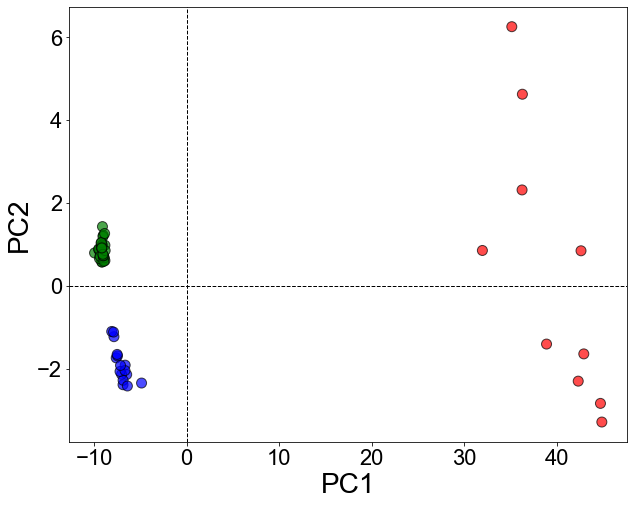

In [13]:
#FIG S1C

# Filter the DataFrame to include only the desired indices and columns
filtered_df = z_scored_df.iloc[:, 51:198][(z_scored_df.index.str.contains("BMP4")) | 
                                          (z_scored_df.index.str.contains("mTeSR")) | 
                                          (z_scored_df.index.str.contains("CHIR-98014"))]

# Perform PCA on the filtered data
pca = PCA(n_components=2)
pca_results = pca.fit_transform(filtered_df)

# Create a DataFrame to store the PCA results
pca_df = pd.DataFrame(data=pca_results, columns=['PCA1', 'PCA2'], index=filtered_df.index)

# Add a color column for plotting
pca_df['color'] = pca_df.index.to_series().apply(
    lambda x: 'blue' if 'BMP4' in x else ('green' if 'mTeSR' in x else 'red')
)

# Create a 2D plot for the PCA results
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], color=pca_df['color'], edgecolor='k', alpha=0.7, s=100)  # Increase point size

# Add dashed black lines at x=0 and y=0
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(0, color='black', linestyle='--', linewidth=1)

# Apply Arial font and set font size to 28
plt.xlabel('PC1', fontsize=28, fontname='Arial')
plt.ylabel('PC2', fontsize=28, fontname='Arial')

# Adjust tick label font sizes
plt.xticks(fontsize=22, fontname='Arial')
plt.yticks(fontsize=22, fontname='Arial')

# Save the figure in high resolution
plt.savefig('PCA_2D_Visualization.png', dpi=300, bbox_inches='tight')

plt.show()

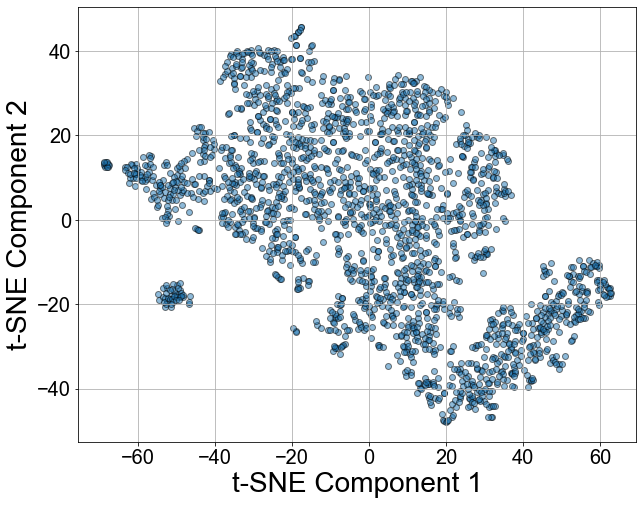

In [14]:
#Running the t-SNE

# Apply t-SNE transformation
tsne = TSNE(n_components=2, random_state=33191)  # 33191 for primary, 8 for alternative embedding

# Define the data for t-SNE
tsne_data = z_scored_df.iloc[:, 51:198]

tsne_results = tsne.fit_transform(tsne_data.values)

# Plot the 2D t-SNE result
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], edgecolor='k', alpha=0.5)

# Apply Arial font and set font size to 28
plt.xlabel('t-SNE Component 1', fontsize=28, fontname='Arial')
plt.ylabel('t-SNE Component 2', fontsize=28, fontname='Arial')
#plt.title('t-SNE', fontsize=28, fontname='Arial')
plt.grid(True)

# Adjust tick label font sizes
plt.xticks(fontsize=20, fontname='Arial')
plt.yticks(fontsize=20, fontname='Arial')

# Save the figure in high resolution
plt.savefig('t-SNE_Visualization.png', dpi=300, bbox_inches='tight')

plt.show()

In [15]:
#ADD DRUG INFO to DF

index_values = z_scored_df.index.values
cell_counts = z_scored_df['total cells'].values
plate_values = z_scored_df['plate'].values
drug_target = z_scored_df['target'].values

# Create a new DataFrame with index set to index_values
tsne_df = pd.DataFrame(tsne_results, columns=['tsne_1', 'tsne_2'], index=index_values)

# Add the "cell count" column to the new DataFrame
tsne_df['total cells'] = cell_counts

# Add the "plate" column to the new DataFrame
tsne_df['plate'] = plate_values

# Add the "plate" column to the new DataFrame
tsne_df['target'] = drug_target

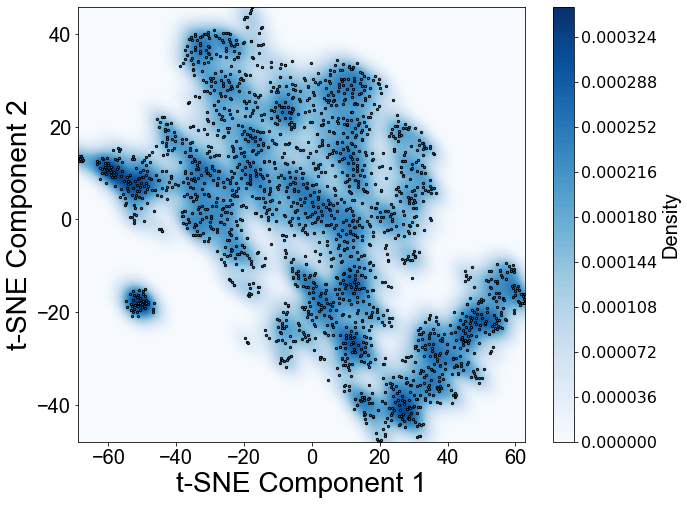

In [16]:
#CLUSTERING ALGORITHM - STEP 1

# Assuming tsne_results is your 2D t-SNE data
x = tsne_results[:, 0]
y = tsne_results[:, 1]

# Calculate the aspect ratio of the t-SNE plot
aspect_ratio_tsne = (np.max(y) - np.min(y)) / (np.max(x) - np.min(x))

# Determine the number of points for x
num_points_x = 500

# Calculate the number of points for y to maintain the aspect ratio
num_points_y = int(num_points_x * aspect_ratio_tsne)

# KDE
kde = gaussian_kde(np.vstack([x, y]), bw_method=0.1)
X, Y = np.meshgrid(np.linspace(np.min(x), np.max(x), num_points_x), 
                   np.linspace(np.min(y), np.max(y), num_points_y))
Z = kde.evaluate(np.vstack([X.ravel(), Y.ravel()]))

# Reshape back into a 2D grid
Z = Z.reshape(X.shape)

# Plot the topological surface
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, Z, levels=100, cmap="Blues")

# Create and customize the color bar
cbar = plt.colorbar()
cbar.set_label("Density", fontsize=20, fontname='Arial')
cbar.ax.tick_params(labelsize=16)

# Scatter plot of the original t-SNE points
plt.scatter(x, y, s=5, edgecolor='k')

# Apply Arial font and set font size to 28
#plt.title("t-SNE Density and Segmentation", fontsize=28, fontname='Arial')
plt.xlabel("t-SNE Component 1", fontsize=28, fontname='Arial')
plt.ylabel("t-SNE Component 2", fontsize=28, fontname='Arial')

# Adjust tick label font sizes
plt.xticks(fontsize=20, fontname='Arial')
plt.yticks(fontsize=20, fontname='Arial')

# Save the figure in high resolution
plt.savefig('t-SNE_KDE.png', dpi=300, bbox_inches='tight')

plt.show()

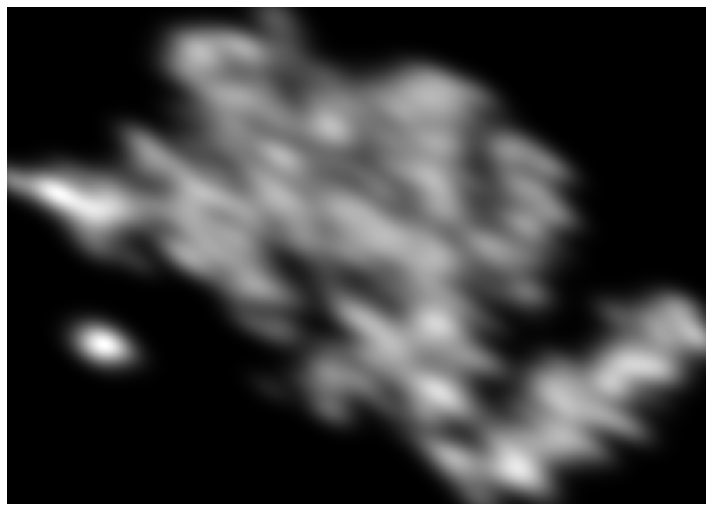

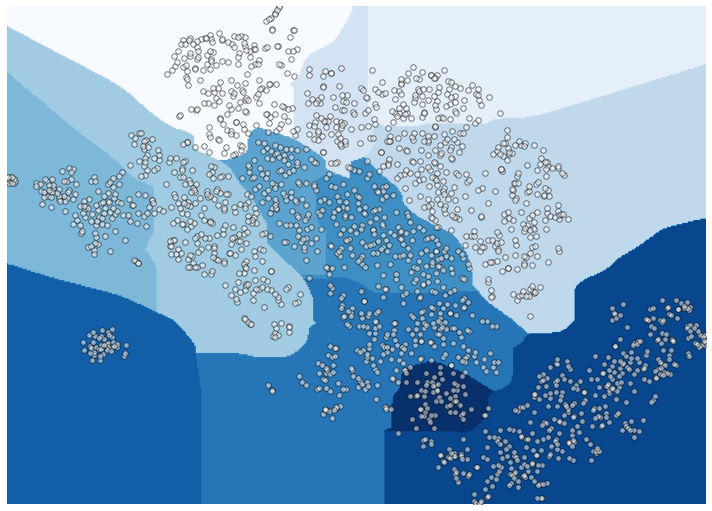

In [17]:
#CLUSTERING ALGORITHM - STEP 2

# Perform watershed segmentation
Z_flipped = np.flipud(Z)
local_maxi = peak_local_max(Z_flipped, indices=False, min_distance=33) #58 for alternative embedding
markers, _ = ndimage.label(local_maxi)
labels = watershed(-Z_flipped, markers)

# Plot the original image
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.imshow(Z_flipped, cmap='gray', aspect='equal')
#ax1.set_title('Original Image')
ax1.axis('off')

plt.tight_layout()
plt.savefig('Original_Image.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot the segmented regions with the custom colormap
fig2, ax2 = plt.subplots(figsize=(10, 8))
ax2.imshow(labels, cmap='Blues', extent=[min(x), max(x), min(y), max(y)])
ax2.scatter(x, y, c='white', edgecolors='black', s=30, alpha=0.5)
#ax2.set_title('Segmented regions')

ax2.axis('off')

plt.tight_layout()
plt.savefig('Segmented_regions.png', dpi=300, bbox_inches='tight')
plt.show()

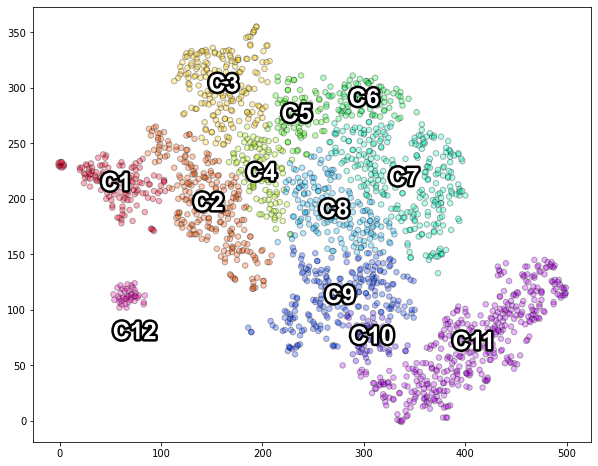

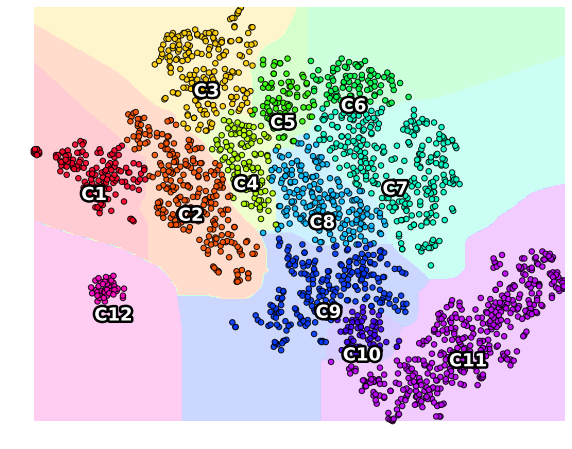

In [23]:
# VIZUALIZE CLUSTERS
Z_flipped = np.flipud(Z)
x = tsne_results[:, 0]
y = tsne_results[:, 1]

# Calculate the dimensions of Z
height, width = Z_flipped.shape

# Rescale the coordinates to match the size of Z_flipped
x_rescale = (x - min(x)) / (max(x) - min(x)) * Z_flipped.shape[1]
y_rescale = (y - min(y)) / (max(y) - min(y)) * Z_flipped.shape[0]

# Label the points by watershed region
y_rescale = np.round(y_rescale).astype(int) - 1
x_rescale = np.round(x_rescale).astype(int) - 1

# Initialize point_labels
point_labels = np.zeros(len(x_rescale))
labels_flipped = np.flipud(labels)

label_map = {
    6: 1, 1: 3, 5: 2, 7: 4, 3: 5, 2: 6, 4: 7, 12: 10, 10: 12,
}

# Specific entries to update due to edge effects
specific_entries = {
    'CHIR-99021 (CT99021)': 1.0,
    'CHIR-98014_3': 1.0,
    'Isotretinoin_10': 12.0
}

# Create a map of index positions for the specific entries
index_map = {entry: i for i, entry in enumerate(tsne_df.index)}

# Retrieve and map labels
for i in range(len(x_rescale)):
    xi = x_rescale[i]
    yi = y_rescale[i]
    original_label = labels_flipped[yi, xi]
    mapped_label = label_map.get(original_label, original_label)  # Default to original if not in map
    point_labels[i] = mapped_label

# Update point_labels for specific entries
for entry, new_label in specific_entries.items():
    if entry in index_map:
        index = index_map[entry]
        point_labels[index] = new_label

# Apply label mapping to the entire labels_flipped array
remapped_labels_flipped = np.copy(labels_flipped)  # Create a copy to avoid modifying the original data

# Apply the mapping to each label
for old_label, new_label in label_map.items():
    remapped_labels_flipped[labels_flipped == old_label] = new_label

# Visualization
# Figure 1: Original Image with Scatter
fig1, ax1 = plt.subplots(figsize=(10, 8))
scatter1 = ax1.scatter(x_rescale, y_rescale, c=point_labels, edgecolors='black', s=30, alpha=0.3, cmap='gist_rainbow')

# Create a dictionary to store the unique labels and their coordinates
label_coords = defaultdict(list)

my_effect = path_effects.withStroke(foreground='black', linewidth=2)

# Add points to the dictionary
for x_coord, y_coord, label in zip(x_rescale, y_rescale, point_labels):
    label_coords[label].append((x_coord, y_coord))

# Set the desired font properties
font = FontProperties()
font.set_family('sans-serif')
font.set_name('Arial')

# Add text annotations for each unique label's centroid
my_effect = path_effects.withStroke(foreground='black', linewidth=5)
for label, coords in label_coords.items():
    x_coords, y_coords = zip(*coords)
    centroid_x = sum(x_coords) / len(x_coords)
    centroid_y = sum(y_coords) / len(y_coords)
    
    # Update the label to include the 'C' prefix
    cluster_label = f"C{int(label)}"
    
    if int(label) == 12:
        text = ax1.text(centroid_x, centroid_y - 20, cluster_label, fontsize=24, color='white', weight='bold', va='top', ha='center', fontproperties=font)
    else:
        text = ax1.text(centroid_x, centroid_y, cluster_label, fontsize=24, color='white', weight='bold', va='center', ha='center', fontproperties=font)
        
    text.set_path_effects([my_effect])

# Save the figure
fig1.savefig('figure5.jpg', dpi=300, bbox_inches='tight')

# Figure 2: Segmented regions with Scatter
fig2, ax2 = plt.subplots(figsize=(10, 8))
ax2.imshow(remapped_labels_flipped, cmap='gist_rainbow', alpha=0.2, aspect='auto', origin='lower')
scatter2 = ax2.scatter(x_rescale, y_rescale, c=point_labels, edgecolors='black', s=30, alpha=0.9, cmap='gist_rainbow')
#ax2.set_title('Segmented regions')
ax2.axis('off')

# Add text annotations for each unique label's centroid
for label, coords in label_coords.items():
    x_coords, y_coords = zip(*coords)
    centroid_x = sum(x_coords) / len(x_coords)
    centroid_y = sum(y_coords) / len(y_coords)
    
    # Define cluster_label inside the loop
    cluster_label = f"C{int(label)}"
    
    text = ax2.text(centroid_x, centroid_y - 20, cluster_label, fontsize=18, weight='bold', color='white', va='center', ha='center')
    text.set_path_effects([my_effect])

# Save the updated Figure 2
fig2.savefig('figure6.jpg', dpi=300, bbox_inches='tight')

plt.show()

In [24]:
#CREATE NEW DF

# Selecting idx, tsne_1, and tsne_2 from tsne_df
tsne_selected = tsne_df[['tsne_1', 'tsne_2']]

# Selecting columns 51 to 197 from z_scored_df
z_scored_selected = z_scored_df.iloc[:, 51:198]  

# Merging the selected columns
TSNE_MAP = pd.concat([tsne_selected, z_scored_selected], axis=1)

# Exporting to Excel
TSNE_MAP.to_excel('TSNE_MAP.xlsx', index=True)

In [25]:
#FILTER BY DRUG INDEX

# Add the "c_values" column to the new DataFrame
tsne_df['cluster'] = point_labels

# Create a boolean mask to filter rows with "drug name" in the index
idx = tsne_df.index.str.contains("DEL")

# Use the mask to filter the DataFrame
filtered_df = tsne_df[idx]
filtered_df

# Sort the filtered DataFrame by "total cells" in ascending order
sorted_filtered_df = filtered_df.sort_values(by='total cells', ascending=True)

# Display the sorted DataFrame
sorted_filtered_df

tsne_1     tsne_2  total cells plate target  cluster
DEL-22379_6 -61.433029  12.961097          747     E    ERK      1.0
DEL-22379_7 -60.531002  13.328135          764     E    ERK      1.0
DEL-22379_4 -37.267948  34.551128          790     E    ERK      3.0
DEL-22379_5 -35.492889  36.092194          790     E    ERK      3.0
DEL-22379_2 -31.057211  27.590254          817     E    ERK      3.0
DEL-22379_8 -36.910091  35.379929          838     E    ERK      3.0
DEL-22379_3 -35.752548  34.398094          840     E    ERK      3.0
DEL-22379   -33.101280  35.902222          859     E    ERK      3.0
DEL-22379_9 -34.378975  39.947121          969     E    ERK      3.0

In [27]:
#FILTER BY CLUSTER

# Set the display option to show all rows
pd.set_option('display.max_rows', None)

# Specify the value you want to filter by
specified_value = 3.0  # Replace with the desired value

# Create a boolean mask to filter rows with the specified value in point_labels
mask = (tsne_df['cluster'] == specified_value)

# Use the mask to filter the DataFrame
filtered_df = tsne_df[mask]

filtered_df

tsne_1     tsne_2  \
SH-4-54                                        -19.015947  41.560219   
SH-4-54_2                                      -19.018101  41.360054   
SH-4-54_3                                      -19.131893  43.564095   
SH-4-54_4                                      -27.213959  35.273857   
SH-4-54_5                                      -20.149761  43.083076   
UM729                                          -18.360394  44.545372   
UM729_2                                        -18.362835  44.449627   
UM729_3                                        -17.589653  45.817986   
8-Bromo-cAMP                                   -24.218512  22.743761   
8-Bromo-cAMP_3                                 -24.460312  23.582439   
8-Bromo-cAMP_4                                 -26.748091  31.895115   
8-Bromo-cAMP_5                                 -15.247744  26.755562   
8-Bromo-cAMP_8                                 -25.763330  24.003622   
8-Bromo-cAMP_9                                 -18.580696  27.449938   
8-Bromo-cAMP_10                                -25.825239  23.976709   
Nemiralisib (GSK2269557)_8                     -30.828568  18.423105   
Dibutyryl-cAMP (Bucladesine)_8                 -18.217207  31.194622   
FR 180204_11                                   -14.778872  32.779385   
BMP4_6                                         -32.466385  31.900551   
Isoxazole 9 (ISX-9)                            -24.781956  40.224365   
Isoxazole 9 (ISX-9)_2                          -26.215664  40.156956   
Isoxazole 9 (ISX-9)_3                          -27.321625  39.113144   
Isoxazole 9 (ISX-9)_4                          -25.451952  40.087006   
Isoxazole 9 (ISX-9)_5                          -35.774689  39.393646   
Isoxazole 9 (ISX-9)_6                          -28.346306  39.513763   
Isoxazole 9 (ISX-9)_7                          -26.598001  38.760002   
Isoxazole 9 (ISX-9)_8                          -36.110641  38.770676   
HPI-4 (Ciliobrevin A)_3                        -18.157211  22.355223   
ZM 39923 HCl                                   -15.919416  37.486721   
Smoothened Agonist (SAG) HCl_6                 -17.677372  45.721729   
Smoothened Agonist (SAG) HCl_7                 -18.044237  45.070747   
DEL-22379                                      -33.101280  35.902222   
DEL-22379_2                                    -31.057211  27.590254   
DEL-22379_3                                    -35.752548  34.398094   
DEL-22379_4                                    -37.267948  34.551128   
DEL-22379_5                                    -35.492889  36.092194   
DEL-22379_8                                    -36.910091  35.379929   
DEL-22379_9                                    -34.378975  39.947121   
IMR-1_4                                        -20.244604  38.066814   
IMR-1_5                                        -30.195444  37.133179   
IMR-1_6                                        -23.038261  37.414742   
IMR-1_7                                        -22.303314  38.564705   
IMR-1_9                                        -24.136774  38.337933   
umbralisib (TGR-1202)_3                        -22.332716  37.801605   
SH5-07 (SH-5-07)_2                             -30.604181  40.355659   
SH5-07 (SH-5-07)_3                             -31.651052  39.945877   
SH5-07 (SH-5-07)_4                             -28.443134  39.742844   
SH5-07 (SH-5-07)_5                             -32.376804  39.584152   
SH5-07 (SH-5-07)_6                             -30.533455  39.637722   
SH5-07 (SH-5-07)_7                             -31.497246  39.895802   
SH5-07 (SH-5-07)_8                             -28.883093  40.807781   
MK-4101_8                                      -33.274647  26.293427   
Bikinin_7                                      -23.817711  25.892597   
Bikinin_8                                      -24.072111  26.142363   
Tenalisib (RP6530)_3                           -36.514202  25.141382   
Magnolin_4         

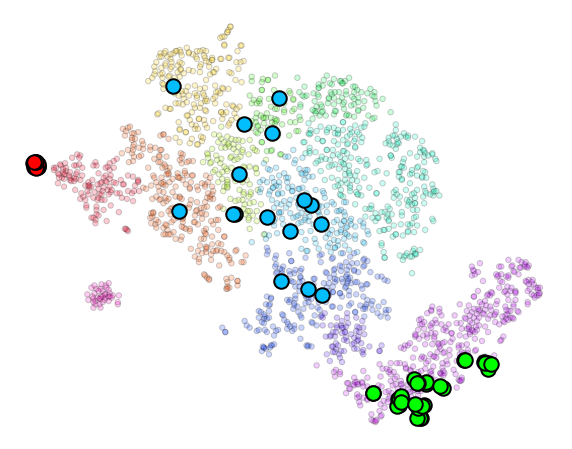

In [28]:
#SHOW CONTROL TREATMENTS IN t-SNE

# Create a filter for rows where the index contains 'mTeSR', 'BMP4', or 'CHIR-98014'
mtesr_idx = tsne_df.index.str.contains("mTeSR")
bmp4_idx = tsne_df.index.str.contains("BMP4")
chir_idx = tsne_df.index.str.contains("CHIR-98014")

plt.figure(figsize=(10, 8))

# Plot all remaining points based on their point_labels with gist_rainbow colormap
scatter1 = plt.scatter(x_rescale, y_rescale, c=point_labels, edgecolors='black', s=30, alpha=0.2, cmap='gist_rainbow')

# Plotting points for 'mTeSR', 'BMP4', and 'CHIR-98014' in specified colors
for label, color in zip(['mTeSR', 'BMP4', 'CHIR-98014'], ['#01FF00', '#03BEFE', 'red']):
    # Specific indices for each label
    idx = tsne_df.index.str.contains(label)
    
    x_label = x_rescale[idx]
    y_label = y_rescale[idx]

    plt.scatter(x_label, y_label, edgecolors='black', s=210, color=color, linewidths=2)



plt.axis('off')
plt.savefig("figure10.jpg", dpi=300, bbox_inches='tight')
plt.show()

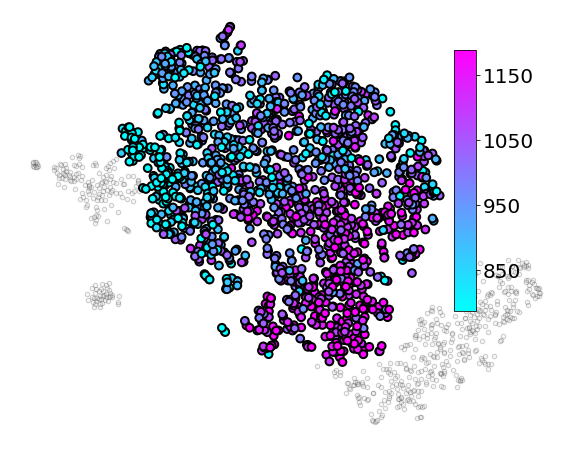

Figure saved successfully.


In [29]:
#PLOT BY DENSITY IN CANONICAL PATTERNING REGION

# Calculate the 10th and 90th percentiles
lower_percentile, upper_percentile = np.percentile(tsne_df['total cells'], [10, 90])

# Filter points to include only clusters 2-10
filtered_indices = tsne_df['cluster'].isin(range(2, 11))

# Extract the filtered x, y values
x_filtered = tsne_df.loc[filtered_indices, 'tsne_1']
y_filtered = tsne_df.loc[filtered_indices, 'tsne_2']
total_cells_filtered = tsne_df.loc[filtered_indices, 'total cells']

# Rescale the coordinates to match the size of the plot
x_rescale = (tsne_df['tsne_1'] - tsne_df['tsne_1'].min()) / (tsne_df['tsne_1'].max() - tsne_df['tsne_1'].min())
y_rescale = (tsne_df['tsne_2'] - tsne_df['tsne_2'].min()) / (tsne_df['tsne_2'].max() - tsne_df['tsne_2'].min())

# Rescale the filtered coordinates
x_rescale_filtered = (x_filtered - tsne_df['tsne_1'].min()) / (tsne_df['tsne_1'].max() - tsne_df['tsne_1'].min())
y_rescale_filtered = (y_filtered - tsne_df['tsne_2'].min()) / (tsne_df['tsne_2'].max() - tsne_df['tsne_2'].min())

# Visualization
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all points in grey
ax.scatter(x_rescale, y_rescale, color='lightgrey', edgecolors='black', s=20, alpha=0.2)

# Plot filtered points with colors representing total cells
scatter = ax.scatter(x_rescale_filtered, y_rescale_filtered, edgecolors='black', s=60, c=total_cells_filtered, cmap='cool', vmin=lower_percentile, vmax=upper_percentile, linewidths=2)

# Add a horizontal color scale bar (colorbar) using the same normalization
cax = plt.gca().inset_axes([0.8, 0.3, 0.04, 0.6])  # Adjust the location and size as needed
cbar = plt.colorbar(scatter, cax=cax, orientation='vertical')

# Increase the font size and add a title to the colorbar
cbar.ax.tick_params(labelsize=20)  # Increase font size of the ticks
#cbar.set_label('Total Cells', fontsize=24)  # Add a title with increased font size

# Set the ticks and labels on the colorbar
cbar.set_ticks([850, 950, 1050, 1150])
cbar.set_ticklabels(['850', '950', '1050', '1150'])

ax.axis('off')

# Save the figure
plt.savefig('clusters_2_to_10_total_cells.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved successfully.")

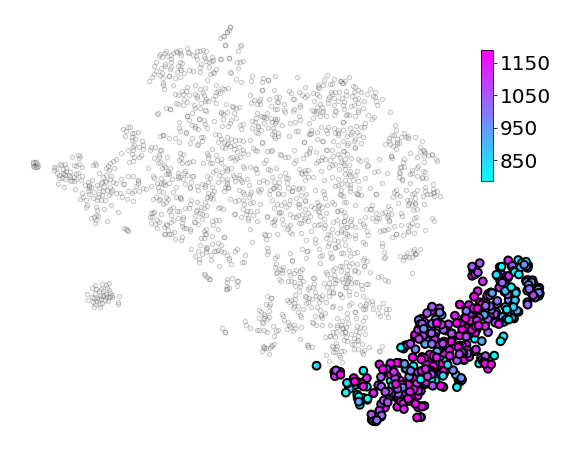

Figure saved successfully.


In [30]:
#PLOT BY DENSITY IN C11

# Calculate the 10th and 90th percentiles
lower_percentile, upper_percentile = np.percentile(tsne_df['total cells'], [10, 90])

# Filter points to include only clusters 2-10
filtered_indices = tsne_df['cluster'].isin(range(11, 12))

# Extract the filtered x, y values
x_filtered = tsne_df.loc[filtered_indices, 'tsne_1']
y_filtered = tsne_df.loc[filtered_indices, 'tsne_2']
total_cells_filtered = tsne_df.loc[filtered_indices, 'total cells']

# Rescale the coordinates to match the size of the plot
x_rescale = (tsne_df['tsne_1'] - tsne_df['tsne_1'].min()) / (tsne_df['tsne_1'].max() - tsne_df['tsne_1'].min())
y_rescale = (tsne_df['tsne_2'] - tsne_df['tsne_2'].min()) / (tsne_df['tsne_2'].max() - tsne_df['tsne_2'].min())

# Rescale the filtered coordinates
x_rescale_filtered = (x_filtered - tsne_df['tsne_1'].min()) / (tsne_df['tsne_1'].max() - tsne_df['tsne_1'].min())
y_rescale_filtered = (y_filtered - tsne_df['tsne_2'].min()) / (tsne_df['tsne_2'].max() - tsne_df['tsne_2'].min())

# Visualization
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all points in grey
ax.scatter(x_rescale, y_rescale, color='lightgrey', edgecolors='black', s=20, alpha=0.2)

# Plot filtered points with colors representing total cells
scatter = ax.scatter(x_rescale_filtered, y_rescale_filtered, edgecolors='black', s=60, c=total_cells_filtered, cmap='cool', vmin=lower_percentile, vmax=upper_percentile, linewidths=2)

# Add a smaller color scale bar (colorbar) using the same normalization
cax = plt.gca().inset_axes([0.85, 0.60, 0.02, 0.3])  # Adjust the location and size as needed
cbar = plt.colorbar(scatter, cax=cax, orientation='vertical')

# Increase the font size and add a title to the colorbar
cbar.ax.tick_params(labelsize=20)  # Increase font size of the ticks

# Set the ticks and labels on the colorbar
cbar.set_ticks([850, 950, 1050, 1150])
cbar.set_ticklabels(['850', '950', '1050', '1150'])

ax.axis('off')

# Save the figure
plt.savefig('clusters_2_to_10_total_cells.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved successfully.")

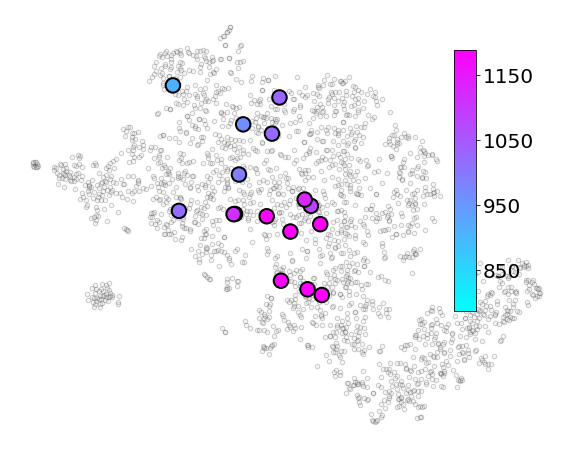

Figure saved successfully.


In [31]:
#PLOT SPECIFIC DRUG INDEX BY DENSITY

# Calculate the percentiles for normalization
lower_percentile, upper_percentile = np.percentile(tsne_df['total cells'], [10, 90])

# Set the colormap
cmap = mpl.cm.cool

# Create a normalization object using the percentiles
norm = mpl.colors.Normalize(vmin=lower_percentile, vmax=upper_percentile)

# Create a boolean mask to filter rows with "BMP" in the index
idx = tsne_df.index.str.contains("BMP4")

# Use the mask to filter the DataFrame
filtered_df = tsne_df[idx]

# Rescale the coordinates for all data
x_rescale = (tsne_df['tsne_1'] - tsne_df['tsne_1'].min()) / (tsne_df['tsne_1'].max() - tsne_df['tsne_1'].min())
y_rescale = (tsne_df['tsne_2'] - tsne_df['tsne_2'].min()) / (tsne_df['tsne_2'].max() - tsne_df['tsne_2'].min())

# Rescale the coordinates for the filtered data
x_rescale_filtered = (filtered_df['tsne_1'] - tsne_df['tsne_1'].min()) / (tsne_df['tsne_1'].max() - tsne_df['tsne_1'].min())
y_rescale_filtered = (filtered_df['tsne_2'] - tsne_df['tsne_2'].min()) / (tsne_df['tsne_2'].max() - tsne_df['tsne_2'].min())

# Visualization
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all points in grey
ax.scatter(x_rescale, y_rescale, color='lightgrey', edgecolors='black', s=20, alpha=0.2)

# Plot filtered points with colors representing total cells
scatter = ax.scatter(x_rescale_filtered, y_rescale_filtered, edgecolors='black', s=210, c=filtered_df['total cells'], cmap=cmap, norm=norm, linewidths=2)

# Add a horizontal color scale bar (colorbar) using the same normalization
cax = plt.gca().inset_axes([0.8, 0.3, 0.04, 0.6])  # Adjust the location and size as needed
cbar = plt.colorbar(scatter, cax=cax, orientation='vertical')

# Increase the font size and add a title to the colorbar
cbar.ax.tick_params(labelsize=20)  # Increase font size of the ticks
#cbar.set_label('Total Cells', fontsize=24)  # Add a title with increased font size

# Set the ticks and labels on the colorbar
cbar.set_ticks([850, 950, 1050, 1150])
cbar.set_ticklabels(['850', '950', '1050', '1150'])

ax.axis('off')

# Save the figure as "BMP4.png"
plt.savefig("BMP4.png", dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved successfully.")

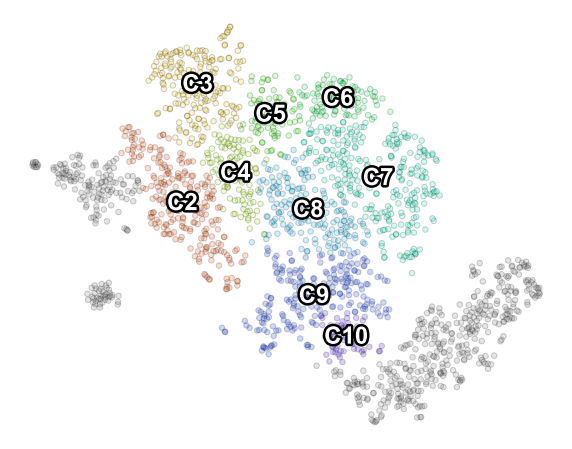

In [34]:
#VIEW CANONICAL PATTERNING CLUSTERS

# Visualization
fig1, ax1 = plt.subplots(figsize=(10, 8))

# Apply color map to all points
cmap = plt.cm.gist_rainbow
norm = mcolors.Normalize(vmin=np.min(point_labels), vmax=np.max(point_labels))
colors = cmap(norm(point_labels))

# Apply gray color and lower alpha to labels 1, 11, and 12
transparency_mask = np.isin(point_labels, [1, 11, 12])
colors[transparency_mask] = np.array([0.5, 0.5, 0.5, 0.1])  # Grey and very transparent

scatter1 = ax1.scatter(x_rescale, y_rescale, color=colors, edgecolors='black', s=30, alpha=0.2)

# Create a dictionary to store the unique labels and their coordinates
label_coords = defaultdict(list)

# Add points to the dictionary excluding 1, 11, and 12
for x_coord, y_coord, label in zip(x_rescale, y_rescale, point_labels):
    if label not in [1, 11, 12]:  # Exclude labels 1, 11, and 12
        label_coords[label].append((x_coord, y_coord))

# Add text annotations for each unique label's centroid
my_effect = path_effects.withStroke(foreground='black', linewidth=5)
# Add text annotations for each unique label's centroid
for label, coords in label_coords.items():
    x_coords, y_coords = zip(*coords)
    centroid_x = sum(x_coords) / len(x_coords)
    centroid_y = sum(y_coords) / len(y_coords)
    
    # Update the label to include the 'C' prefix
    cluster_label = f"C{int(label)}"
    
    if int(label) == 12:
        text = ax1.text(centroid_x, centroid_y - 20, cluster_label, fontsize=24, color='white', weight='bold', va='top', ha='center', fontproperties=font)
    else:
        text = ax1.text(centroid_x, centroid_y, cluster_label, fontsize=24, color='white', weight='bold', va='center', ha='center', fontproperties=font)
        
    text.set_path_effects([my_effect])

ax1.axis('off')

# Save the figure
fig1.savefig('figure5.jpg', dpi=300, bbox_inches='tight')
plt.show()

# Create a dataframe to store indices and point labels
data = {'Index': np.arange(len(point_labels)), 'Point_Label': point_labels}
df = pd.DataFrame(data)

# Save the dataframe to an Excel workbook
df.to_excel('point_labels.xlsx', index=False)

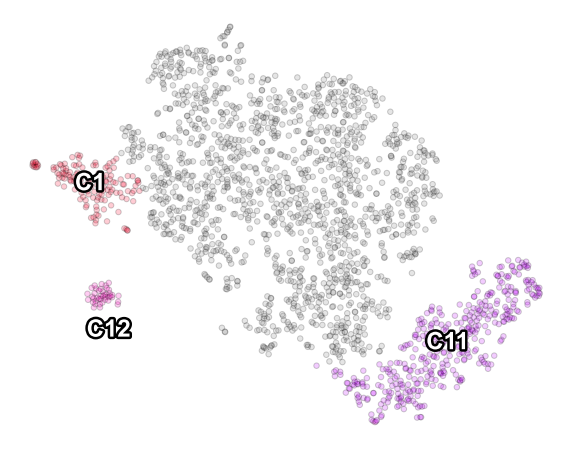

In [35]:
#VIEW NON-CANONICAL PATTERNING CLUSTERS

# Visualization
fig1, ax1 = plt.subplots(figsize=(10, 8))

# Apply gray color and lower alpha to all points
colors = np.array([[0.5, 0.5, 0.5, 0.1]] * len(point_labels))

# Apply color map to labels 1, 11, and 12
highlight_labels = [1, 11, 12]
cmap = plt.cm.gist_rainbow
norm = mcolors.Normalize(vmin=np.min(highlight_labels), vmax=np.max(highlight_labels))
highlight_colors = cmap(norm(highlight_labels))

# Update the colors for the highlighted labels
for i, label in enumerate(point_labels):
    if label in highlight_labels:
        colors[i] = highlight_colors[highlight_labels.index(label)]

scatter1 = ax1.scatter(x_rescale, y_rescale, color=colors, edgecolors='black', s=30, alpha=0.2)

# Create a dictionary to store the unique labels and their coordinates
label_coords = defaultdict(list)

# Add points to the dictionary only for labels 1, 11, and 12
for x_coord, y_coord, label in zip(x_rescale, y_rescale, point_labels):
    if label in [1, 11, 12]:
        label_coords[label].append((x_coord, y_coord))

# Add text annotations for each unique label's centroid
my_effect = path_effects.withStroke(foreground='black', linewidth=5)

for label, coords in label_coords.items():
    x_coords, y_coords = zip(*coords)
    centroid_x = sum(x_coords) / len(x_coords)
    centroid_y = sum(y_coords) / len(y_coords)
    
    # Update the label to include the 'C' prefix
    cluster_label = f"C{int(label)}"
    
    if int(label) == 12:
        text = ax1.text(centroid_x, centroid_y - .05, cluster_label, fontsize=24, color='white', weight='bold', va='top', ha='center', fontproperties=font)
    else:
        text = ax1.text(centroid_x, centroid_y, cluster_label, fontsize=24, color='white', weight='bold', va='center', ha='center', fontproperties=font)
        
    text.set_path_effects([my_effect])

ax1.axis('off')

# Save the figure with high resolution
fig1.savefig('highlighted_clusters_high_res.jpg', dpi=300, bbox_inches='tight')
plt.show()

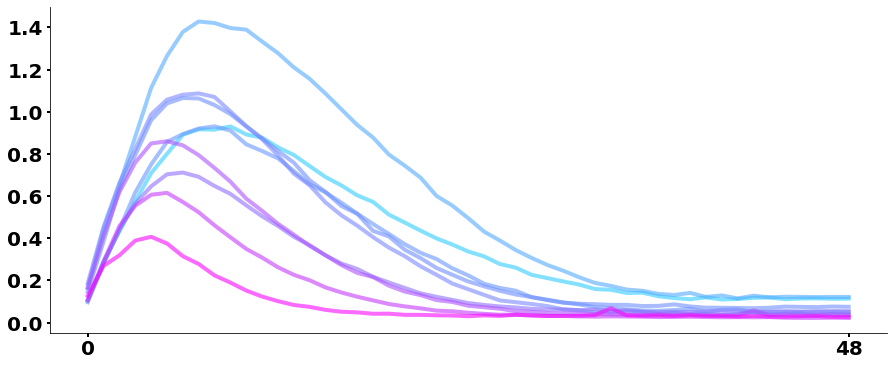

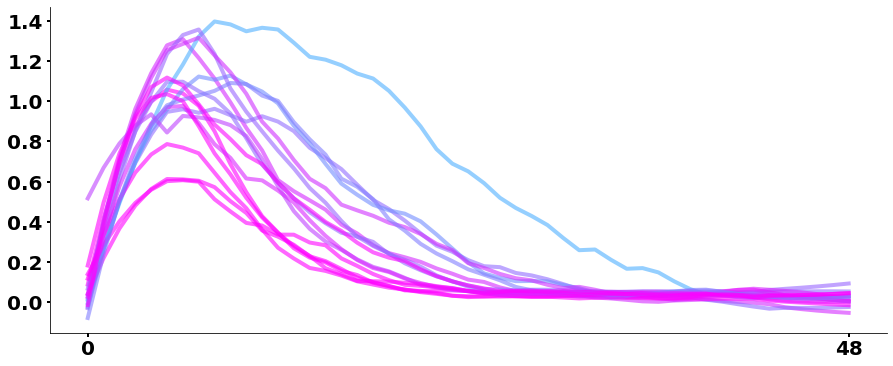

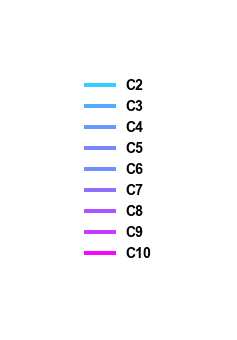

In [37]:
#PLOT BRA INTENSITY IN CONTROLS AND MEAN CLUSTERS

z_scored_df['cluster'] = point_labels

# Calculate mean total cells for each cluster
mean_total_cells = z_scored_df.groupby('cluster')['total cells'].mean()

mean_intensities = z_scored_df.groupby('cluster').mean().iloc[:, 99:148]

# Normalize drug names by removing numerical suffixes to group by drug type
z_scored_df['Drug'] = z_scored_df.index.to_series().str.replace(r'_\d+', '', regex=True)

# Function to apply Savitzky-Golay filter to smooth the data
def smooth_data(series, window_size=9, poly_order=2):
    return savgol_filter(series, window_length=window_size, polyorder=poly_order)

# Function to plot BRA intensity for clusters
def plot_bra_intensity_for_clusters(mean_intensities, mean_total_cells, cmap, norm):
    clusters_to_include = list(range(2, 11))

    # Plotting the results
    plt.figure(figsize=(15, 6))

    # Assuming 'bins' are the x-axis labels for the BRA intensity
    bins = np.arange(mean_intensities.shape[1])

    # Plot each cluster's mean BRA intensity with color representing the total cells
    for i, cluster in enumerate(clusters_to_include):
        color = cmap(norm(mean_total_cells[cluster]))
        plt.plot(bins, mean_intensities.loc[cluster], linewidth=4, color=color, alpha=0.6)

    # Removing titles and labels
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')

    # Set tick marks only at 0 and 48 and make ticks thicker
    plt.xticks([0, 48], fontsize=20, weight='bold')
    plt.yticks(fontsize=20, weight='bold')
    plt.tick_params(axis='both', which='major', width=2)

    # Remove the top and right spine
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Removing grid lines
    plt.grid(False)

    # Save the plot to a file
    plt.savefig('BRA_intensity_with_total_cells_as_color.png')

    # Show the plot
    plt.show()

# Function to plot BMP4 colonies
def plot_bmp4_colonies(z_scored_df, mean_intensities, cmap, norm):
    bmp4_data = z_scored_df[z_scored_df['Drug'] == 'BMP4']

    # Ensure bmp4_data indices are aligned
    bmp4_bra_columns = z_scored_df.loc[bmp4_data.index, z_scored_df.columns[100:149]]

    # Plotting the results
    plt.figure(figsize=(15, 6))

    # Assuming 'bins' are the x-axis labels for the BRA intensity
    bins = np.arange(bmp4_bra_columns.shape[1])

    # Plot each BMP4's mean BRA intensity with color representing the total cells
    for i in range(bmp4_bra_columns.shape[0]):
        color = cmap(norm(bmp4_data.iloc[i]['total cells']))
        smoothed_data = smooth_data(bmp4_bra_columns.iloc[i])
        plt.plot(bins, smoothed_data, linewidth=4, color=color, alpha=0.6)

    # Removing titles and labels
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')

    # Set tick marks only at 0 and 48 and make ticks thicker
    plt.xticks([0, 48], fontsize=20, weight='bold')
    plt.yticks(fontsize=20, weight='bold')
    plt.tick_params(axis='both', which='major', width=2)

    # Remove the top and right spine
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Removing grid lines
    plt.grid(False)

    # Save the plot to a file
    plt.savefig('BMP4_intensity_with_total_cells_as_color.png')

    # Show the plot
    plt.show()

# Function to create a separate legend figure with updated line thickness and font
def create_legend_figure(clusters_to_include, mean_total_cells, cmap, norm):
    fig, ax = plt.subplots(figsize=(4, 6))
    
    # Create a dummy plot to generate legend handles with specified line thickness
    for cluster in clusters_to_include:
        color = cmap(norm(mean_total_cells[cluster]))
        ax.plot([], [], color=color, linewidth=4, label=f'C{cluster}')  # Set linewidth to 4
    
    # Update legend font to Arial, bold and increase the size if needed
    legend = ax.legend(frameon=False, loc='center', prop={'family': 'Arial', 'weight': 'bold', 'size': 14})
    
    ax.axis('off')
    
    plt.savefig('cluster_legend.png')
    plt.show()

# Calculate the percentiles for normalization
lower_percentile, upper_percentile = np.percentile(tsne_df['total cells'], [10, 90])

# Set the colormap
cmap = mpl.cm.cool

# Create a normalization object using the percentiles
norm = mpl.colors.Normalize(vmin=lower_percentile, vmax=upper_percentile)

# Plot the BRA intensity for clusters
plot_bra_intensity_for_clusters(mean_intensities, mean_total_cells, cmap, norm)

# Plot the BMP4 colonies
plot_bmp4_colonies(z_scored_df, mean_intensities, cmap, norm)

# Create and save the legend figure
create_legend_figure(list(range(2, 11)), mean_total_cells, cmap, norm)

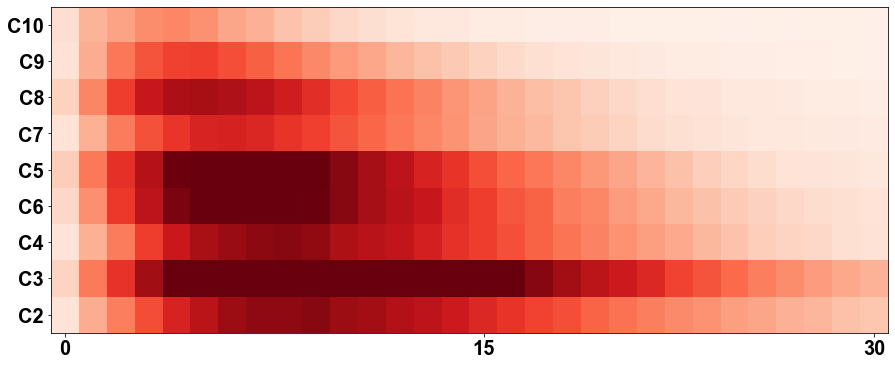

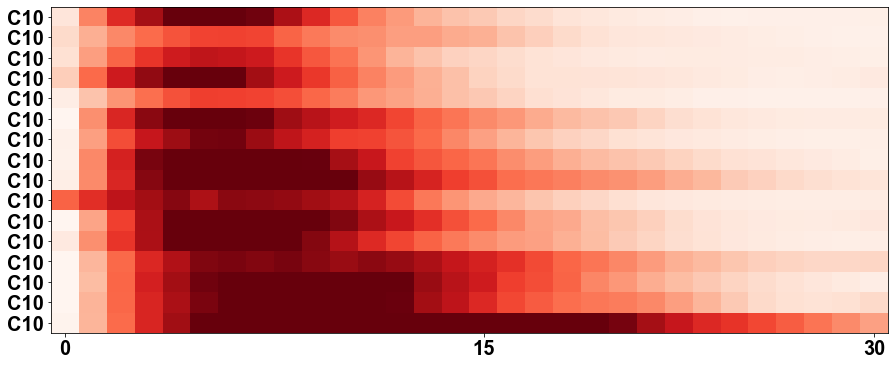

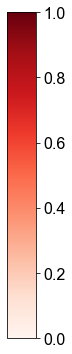

In [38]:
#FIGURE 3B and 3D

# Set the global font to Arial
plt.rcParams['font.family'] = 'Arial'

# Function to apply Savitzky-Golay filter to smooth the data
def smooth_data(series, window_size=9, poly_order=2):
    return savgol_filter(series, window_length=window_size, polyorder=poly_order)

# Function to normalize the combined dataset of mean intensities and smoothed BMP4 data
def calculate_combined_norm(mean_intensities, bmp4_bra_columns, excluded_clusters):
    # Filter out the excluded clusters from mean_intensities
    filtered_mean_intensities = mean_intensities.loc[~mean_intensities.index.isin(excluded_clusters)]
    
    # Combine the data from the filtered mean intensities and BMP4 columns
    all_data = np.concatenate([filtered_mean_intensities.to_numpy().flatten(), bmp4_bra_columns.to_numpy().flatten()])
    
    # Return a normalization object based on the filtered data
    return mpl.colors.Normalize(vmin=np.min(all_data), vmax=1)#0.75*np.max(all_data))

# Function to create a heatmap for clusters ordered by mean_total_cells
def create_heatmap_for_clusters(mean_intensities, mean_total_cells, cmap, norm, excluded_clusters):
    # Remove the excluded clusters
    filtered_indices = mean_total_cells[~mean_total_cells.index.isin(excluded_clusters)].sort_values(ascending=True).index
    filtered_intensities = mean_intensities.loc[filtered_indices].iloc[:, :30]  # Only take the first 30 bins

    plt.figure(figsize=(15, 6))
    heatmap_data = filtered_intensities.to_numpy()
    plt.imshow(heatmap_data, aspect='auto', cmap=cmap, norm=norm)
    
    plt.xticks([0, 15, 29], ['0', '15', '30'], fontsize=20, weight='bold')  # Adjust xticks for first 30 bins

    # Update y-axis labels to show C2, C3, etc.
    y_labels = [f'C{int(label)}' for label in filtered_indices]
    plt.yticks(range(len(filtered_indices)), y_labels, fontsize=20, weight='bold')
    
    plt.gca().invert_yaxis()  # Ensure highest mean_total_cells is at the top
    plt.savefig('cluster_heatmap_ordered.png')
    plt.show()

# Function to create a heatmap for BMP4 colonies ordered by 'total cells'
def create_heatmap_for_bmp4(z_scored_df, bmp4_bra_columns, cmap, norm, excluded_clusters):
    # Remove the excluded clusters
    bmp4_data = z_scored_df[(z_scored_df['Drug'] == 'BMP4') & (~z_scored_df['cluster'].isin(excluded_clusters))]
    ordered_indices = bmp4_data['total cells'].sort_values(ascending=True).index
    ordered_bmp4_columns = bmp4_bra_columns.loc[ordered_indices].iloc[:, :30]  # Only take the first 30 bins
    ordered_smoothed_data = [smooth_data(ordered_bmp4_columns.iloc[i]) for i in range(ordered_bmp4_columns.shape[0])]

    plt.figure(figsize=(15, 6))
    heatmap_data = np.array(ordered_smoothed_data)
    plt.imshow(heatmap_data, aspect='auto', cmap=cmap, norm=norm)
    
    plt.xticks([0, 15, 29], ['0', '15', '30'], fontsize=20, weight='bold')  # Adjust xticks for first 30 bins
    
    # Set all y-ticks to label "C10"
    plt.yticks(range(len(ordered_indices)), ['C10'] * len(ordered_indices), fontsize=20, weight='bold')
    
    plt.gca().invert_yaxis()  # Ensure highest total cells is at the top
    plt.savefig('bmp4_heatmap_ordered.png')
    plt.show()

# Function to create a separate vertical colorbar figure
def create_colorbar(cmap, norm):
    fig, ax = plt.subplots(figsize=(1, 6))  # Adjust size for vertical colorbar
    fig.subplots_adjust(left=0.5)  # Adjust the position of the colorbar within the figure
    
    cbar = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical')  # Set to vertical
    
    # Set the colorbar tick labels with the desired font size
    cbar.ax.tick_params(labelsize=16)
    
    plt.savefig('colorbar.png', dpi=300, bbox_inches='tight')
    plt.show()

# Exclude clusters 1, 11, and 12
excluded_clusters = [1, 11, 12]

# Filter BMP4 data
bmp4_data = z_scored_df[z_scored_df['Drug'] == 'BMP4']
bmp4_bra_columns = z_scored_df.loc[bmp4_data.index, z_scored_df.columns[100:149]]

# Normalize to the combined dataset after excluding clusters 1, 11, and 12
norm = calculate_combined_norm(mean_intensities.iloc[:, :30], bmp4_bra_columns.iloc[:, :30], excluded_clusters)

# Set the colormap
cmap = plt.cm.Reds

# Create heatmap for clusters ordered by mean_total_cells
create_heatmap_for_clusters(mean_intensities, mean_total_cells, cmap, norm, excluded_clusters)

# Create heatmap for BMP4 ordered by 'total cells'
create_heatmap_for_bmp4(z_scored_df, bmp4_bra_columns, cmap, norm, excluded_clusters)

# Create a separate vertical colorbar figure
create_colorbar(cmap, norm)

Clusters Fit Line: y = -0.12x + 159.34, R² = 0.96
BMP4 Fit Line: y = -0.08x + 126.94, R² = 0.69


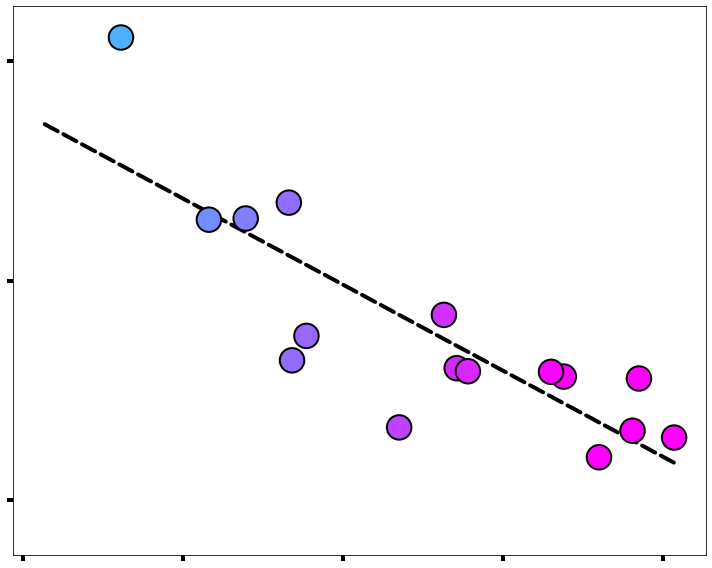

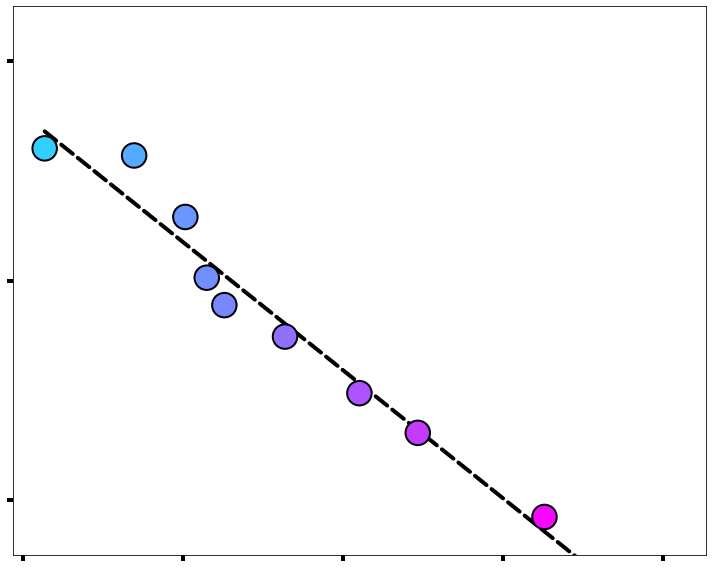

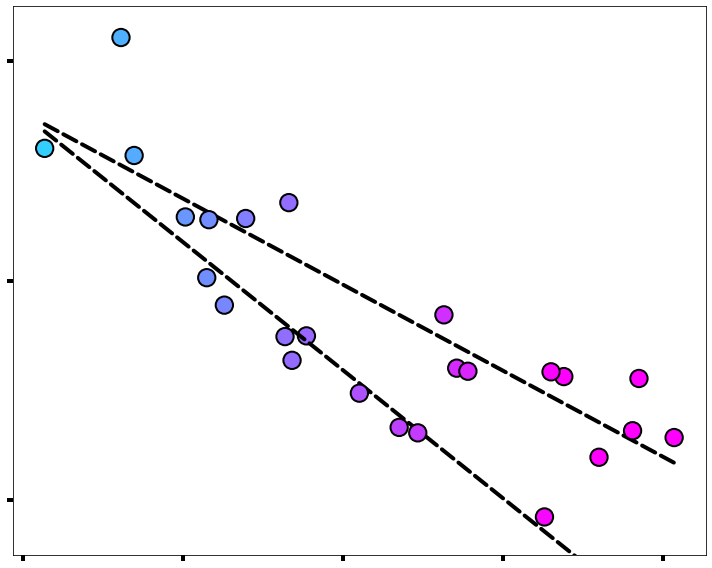

In [39]:
#FIGURE 3A and 3C

# Assuming total_bins is the total number of bins you have
total_bins = len(z_scored_df.columns[100:149])  # Assuming BRA columns are between 100 and 149

# Create bin edges spanning from 0 to max_length_microns
max_length_microns = 253.5
bin_length_microns = max_length_microns / total_bins

# Function to apply Savitzky-Golay filter to smooth the data
def smooth_data(series, window_size=9, poly_order=2):
    return savgol_filter(series, window_length=window_size, polyorder=poly_order)

# Define a Gaussian function to fit
def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x - cen) ** 2 / (2 * wid ** 2))

# Function to find the peak location
def find_peak_location(intensities):
    # Smooth the data
    smoothed_intensities = smooth_data(intensities)

    # Fit a Gaussian curve to the smoothed data
    popt, _ = curve_fit(gaussian, np.arange(len(smoothed_intensities)), smoothed_intensities, p0=[1, np.argmax(smoothed_intensities), 1])
    
    # The peak location in microns
    peak_location_microns = popt[1] * bin_length_microns
    return peak_location_microns

# Calculate peak locations for clusters
peak_locations_clusters = []
clusters_to_include = [cluster for cluster in range(2, 11)]
for cluster in clusters_to_include:
    intensities = mean_intensities.loc[cluster]
    peak_location = find_peak_location(intensities)
    peak_locations_clusters.append(peak_location)

# Group by 'cluster' and calculate the mean of 'total cells' for the relevant clusters
total_cells_mean = z_scored_df[z_scored_df['cluster'].isin(clusters_to_include)].groupby('cluster')['total cells'].mean()

# Create a DataFrame for plotting clusters
plot_df_clusters = pd.DataFrame({
    'Cluster': clusters_to_include,
    'Peak Location Microns': peak_locations_clusters,
    'Total Cells': total_cells_mean
})

# Calculate peak location for BMP4 colonies
bmp4_data = z_scored_df[z_scored_df['Drug'] == 'BMP4']
bmp4_bra_columns = z_scored_df.loc[bmp4_data.index, z_scored_df.columns[100:149]]

bmp4_peak_locations = bmp4_bra_columns.apply(find_peak_location, axis=1)

# Create a DataFrame for BMP4 plotting
plot_df_bmp4 = pd.DataFrame({
    'Total Cells': bmp4_data['total cells'],
    'Peak Location Microns': bmp4_peak_locations
})

# Fit a linear regression line for clusters and BMP4
fit_line_clusters = LinearRegression().fit(plot_df_clusters[['Total Cells']], plot_df_clusters['Peak Location Microns'])
fit_line_bmp4 = LinearRegression().fit(plot_df_bmp4[['Total Cells']], plot_df_bmp4['Peak Location Microns'])

# Calculate the R² values for both fits
r_squared_clusters = fit_line_clusters.score(plot_df_clusters[['Total Cells']], plot_df_clusters['Peak Location Microns'])
r_squared_bmp4 = fit_line_bmp4.score(plot_df_bmp4[['Total Cells']], plot_df_bmp4['Peak Location Microns'])

# Get the equations of the fit lines
slope_clusters = fit_line_clusters.coef_[0]
intercept_clusters = fit_line_clusters.intercept_

slope_bmp4 = fit_line_bmp4.coef_[0]
intercept_bmp4 = fit_line_bmp4.intercept_

# Print the equations and R² values
print(f"Clusters Fit Line: y = {slope_clusters:.2f}x + {intercept_clusters:.2f}, R² = {r_squared_clusters:.2f}")
print(f"BMP4 Fit Line: y = {slope_bmp4:.2f}x + {intercept_bmp4:.2f}, R² = {r_squared_bmp4:.2f}")

# Set global y and x ranges
y_min, y_max = 20, 70
x_min = min(plot_df_bmp4['Total Cells'].min(), plot_df_clusters['Total Cells'].min())
x_max = max(plot_df_bmp4['Total Cells'].max(), plot_df_clusters['Total Cells'].max())

# Get the x-range for both plots
x_range = np.linspace(x_min, x_max, 100)

# Calculate the y-values for the fit lines over the x-range
y_range_clusters = fit_line_clusters.predict(x_range.reshape(-1, 1))
y_range_bmp4 = fit_line_bmp4.predict(x_range.reshape(-1, 1))

# Calculate the percentiles for normalization based on Total Cells
combined_total_cells = np.concatenate([plot_df_clusters['Total Cells'].values, plot_df_bmp4['Total Cells'].values])

# Calculate the 10th and 90th percentiles
lower_percentile, upper_percentile = np.percentile(tsne_df['total cells'], [10, 90])

# Set the colormap and normalization based on Total Cells
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=lower_percentile, vmax=upper_percentile)

# Plot 1: BMP4 with specified y-range and no legend
plt.figure(figsize=(10, 8))

plt.plot(
    x_range,
    y_range_bmp4,
    color='black',
    linestyle='--',
    linewidth=4,
    dash_capstyle='round',
    zorder=1
)

plt.scatter(
    plot_df_bmp4['Total Cells'],
    plot_df_bmp4['Peak Location Microns'],
    c=plot_df_bmp4['Total Cells'],  # Correctly color based on total cells (cell density)
    cmap=cmap,
    norm=norm,
    s=600,  # Increased size for visibility
    edgecolors='black',
    linewidths=2,
    zorder=2
)

plt.ylim([y_min, y_max])  # Set the y-axis range
plt.tick_params(axis='both', which='major', length=6, width=4)
plt.xticks([850, 950, 1050, 1150, 1250], [])  # Keep ticks but remove labels
plt.yticks([25, 45, 65], [])  # Remove numbers from y-axis

# Ensure all spines (borders) are visible
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(True)

plt.grid(False)
plt.tight_layout()
plt.savefig('bmp4_peak_location.png')
plt.show()

# Plot 2: Clusters with specified y-range and no legend
plt.figure(figsize=(10, 8))

plt.plot(
    x_range,
    y_range_clusters,
    color='black',
    linestyle='--',
    linewidth=4,
    dash_capstyle='round',
    zorder=1
)

plt.scatter(
    plot_df_clusters['Total Cells'],
    plot_df_clusters['Peak Location Microns'],
    c=plot_df_clusters['Total Cells'],  # Color based on total cells (cell density)
    cmap=cmap,
    norm=norm,
    s=600,  # Increased size for visibility
    edgecolors='black',
    linewidths=2,
    zorder=2
)

plt.ylim([y_min, y_max])  # Set the y-axis range
plt.tick_params(axis='both', which='major', length=6, width=4)
plt.xticks([850, 950, 1050, 1150, 1250], [])  # Keep ticks but remove labels
plt.yticks([25, 45, 65], [])  # Remove numbers from y-axis

# Ensure all spines (borders) are visible
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(True)

plt.grid(False)
plt.tight_layout()
plt.savefig('clusters_peak_location.png')
plt.show()

# Plot 3: Combined BMP4 and Clusters with no legend
plt.figure(figsize=(10, 8))

# Plot BMP4
plt.plot(
    x_range,
    y_range_bmp4,
    color='black',
    linestyle='--',
    linewidth=4,
    dash_capstyle='round',
    zorder=1
)

plt.scatter(
    plot_df_bmp4['Total Cells'],
    plot_df_bmp4['Peak Location Microns'],
    c=plot_df_bmp4['Total Cells'],  # Color based on total cells (cell density)
    cmap=cmap,
    norm=norm,
    s=300,  # Adjusted size for visibility
    edgecolors='black',
    linewidths=2,
    zorder=2
)

# Plot Clusters
plt.plot(
    x_range,
    y_range_clusters,
    color='black',
    linestyle='--',
    linewidth=4,
    dash_capstyle='round',
    zorder=3
)

plt.scatter(
    plot_df_clusters['Total Cells'],
    plot_df_clusters['Peak Location Microns'],
    c=plot_df_clusters['Total Cells'],  # Color based on total cells (cell density)
    cmap=cmap,
    norm=norm,
    s=300,  # Adjusted size for visibility
    edgecolors='black',
    linewidths=2,
    zorder=4
)

plt.ylim([y_min, y_max])  # Set the y-axis range
plt.tick_params(axis='both', which='major', length=6, width=4)
plt.xticks([850, 950, 1050, 1150, 1250], [])  # Keep ticks but remove labels
plt.yticks([25, 45, 65], [])  # Remove numbers from y-axis

# Ensure all spines (borders) are visible
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(True)

plt.grid(False)
plt.tight_layout()
plt.savefig('combined_peak_location.png')
plt.show()

<Figure size 720x720 with 0 Axes>

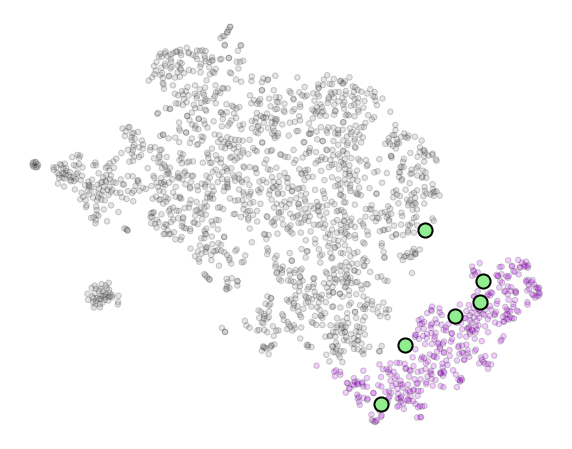

In [40]:
#SHOW NIROGACESTAT TREATED COLONIES

# Create a boolean mask to filter rows with the index
idx = tsne_df.index.str.contains("Nirogacestat")

# Use the mask to filter the DataFrame
filtered_df = tsne_df[idx]

plt.figure(figsize=(10, 10))

# Mask to identify points that belong to cluster 11
mask_red = (point_labels == 11)

# Define colors: gray for all points by default
colors = np.array([[0.5, 0.5, 0.5, 0.4]] * len(point_labels))  # Gray with alpha 0.4

# Apply color map to labels, but only update cluster 11 to its corresponding color
highlight_labels = [11]  # Only highlighting cluster 11
cmap = plt.cm.gist_rainbow
norm = mcolors.Normalize(vmin=np.min(point_labels), vmax=np.max(point_labels))  # Normalize across all labels
highlight_colors = cmap(norm(point_labels))  # Apply the colormap to all labels

# Update the colors for cluster 11
colors[mask_red] = highlight_colors[mask_red]

# Visualization
fig1, ax1 = plt.subplots(figsize=(10, 8))

# Scatter plot with the updated colors
ax1.scatter(x_rescale, y_rescale, color=colors, edgecolors='black', s=30, alpha=0.2)

# Scatter plot for the selected points with "Bex" in the index
x_select = x_rescale[idx]
y_select = y_rescale[idx]

ax1.scatter(x_select, y_select, edgecolors='black', s=200, color='lightgreen', linewidths=2)

ax1.axis('off')

# Save the figure as "figure13" with high resolution
plt.savefig("figure_niro.png", dpi=600, bbox_inches='tight')
plt.show()

Number of unique drugs: 211


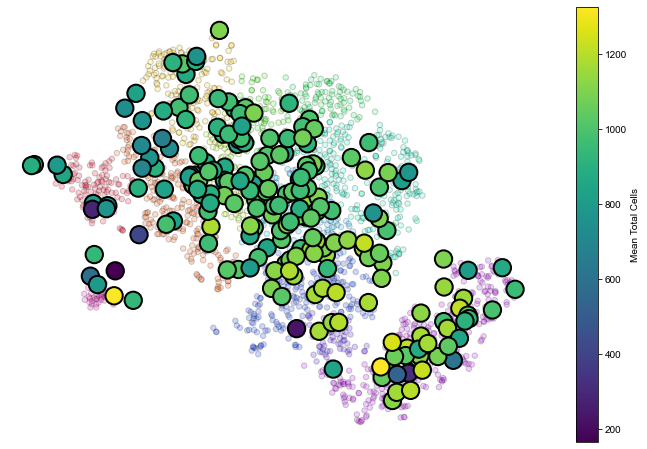

In [41]:
#FIND CENTROID OF EACH DRUG TREATMENT

# VIZUALIZE CLUSTERS
x = tsne_results[:, 0]  # Use the raw t-SNE values for x
y = tsne_results[:, 1]  # Use the raw t-SNE values for y

# Create a copy of tsne_df and normalize drug names by removing numerical suffixes
tsne_df_copy = tsne_df.copy()
tsne_df_copy['Drug'] = tsne_df_copy.index.to_series().str.replace(r'_\d+', '', regex=True)

# Count the number of unique drugs
unique_drugs = tsne_df_copy['Drug'].unique()
print(f"Number of unique drugs: {len(unique_drugs)}")

# Calculate the centroids and mean total cells for each drug condition
centroids = tsne_df_copy.groupby('Drug').agg({
    'tsne_1': 'mean',
    'tsne_2': 'mean',
    'total cells': 'mean'  # Ensure correct column name for mean total cells
}).reset_index()

# Create a table with all drugs, centroid positions, and mean total cells
centroid_table = centroids[['Drug', 'tsne_1', 'tsne_2', 'total cells']]
centroid_table.columns = ['Drug', 'Centroid Position tsne_1', 'Centroid Position tsne_2', 'Mean Total Cells']

# Display the table
#print(centroid_table)

# Plot all points based on their t-SNE values with gist_rainbow colormap
plt.figure(figsize=(12, 8))
scatter1 = plt.scatter(
    x, y, 
    c=point_labels, edgecolors='black', s=30, 
    alpha=0.2, cmap='gist_rainbow'
)

# Plot the centroids of each drug condition over the original plot
norm = plt.Normalize(centroids['total cells'].min(), centroids['total cells'].max())
colormap = plt.cm.viridis  # Choose a colormap to represent mean total cells

# Create a scatter plot for centroids to link with color bar
centroid_scatter = plt.scatter(
    centroids['tsne_1'], centroids['tsne_2'],
    c=centroids['total cells'], cmap=colormap, norm=norm,
    s=300, edgecolors='black', linewidths=2
)

# Format the plot
plt.axis('off')
plt.colorbar(centroid_scatter, label='Mean Total Cells')  # Corrected by associating colorbar with centroid scatter

# Save the figure
plt.savefig("figure10_with_centroids.jpg", dpi=300, bbox_inches='tight')
plt.show()

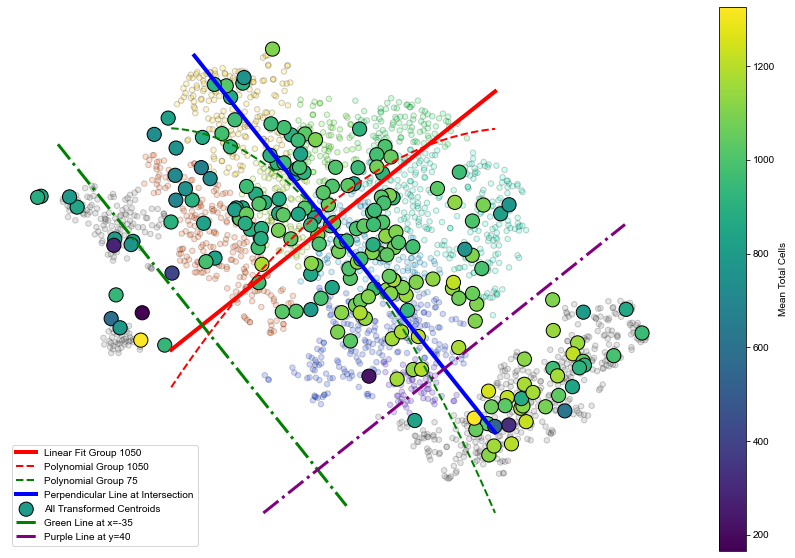

In [42]:
#ADD SOX2 STABILITY AND CELL DENSITY AXES

# Load the data files
df_labels = pd.read_excel('point_labels.xlsx')
poly_coefficients_starting = pd.read_csv('polynomial_coefficients.csv')
poly_coefficients_ending = pd.read_csv('polynomial_coefficients_ending.csv')

# Assume x and y are defined as the t-SNE results of the data points
x = tsne_results[:, 0]  # t-SNE values for x
y = tsne_results[:, 1]  # t-SNE values for y

# Calculate centroids based on drug conditions
tsne_df_copy = tsne_df.copy()
tsne_df_copy['Drug'] = tsne_df_copy.index.to_series().str.replace(r'_\d+', '', regex=True)
centroids = tsne_df_copy.groupby('Drug').agg({
    'tsne_1': 'mean',
    'tsne_2': 'mean',
    'total cells': 'mean'
}).reset_index()

# Step 1: Plotting scatter plot with the linear fit for Group 1050
plt.figure(figsize=(15, 10))
cmap = plt.cm.gist_rainbow
norm = mcolors.Normalize(vmin=np.min(df_labels['Point_Label']), vmax=np.max(df_labels['Point_Label']))
colors = cmap(norm(df_labels['Point_Label'].values))
transparency_mask = np.isin(df_labels['Point_Label'], [1, 11, 12])
colors[transparency_mask] = np.array([0.5, 0.5, 0.5, 0.1])
plt.scatter(x, y, color=colors, edgecolors='black', s=30, alpha=0.2)

# Extracting the relevant polynomials for group_number 1050 and 75
starting_1050 = poly_coefficients_starting[poly_coefficients_starting['Group'] == 1050]
ending_75 = poly_coefficients_ending[poly_coefficients_ending['Group'] == 75]

# Coefficients for the polynomials
coeffs_1050 = [starting_1050.iloc[0]['Coefficient_0'], starting_1050.iloc[0]['Coefficient_1'], starting_1050.iloc[0]['Coefficient_2']]
coeffs_75 = [ending_75.iloc[0][f'Coefficient_{i}'] for i in range(3)]
p_1050 = Polynomial(coeffs_1050)
p_75 = Polynomial(coeffs_75)

# Fit a linear line to the group 1050 polynomial
x_fit = np.linspace(-40, 30, 1000)  # Adjust range as needed
y_1050 = p_1050(x_fit)
linear_fit_1050 = np.polyfit(x_fit, y_1050, 1)
linear_1050 = np.poly1d(linear_fit_1050)

# Plot the linear line for Group 1050
plt.plot(x_fit, linear_1050(x_fit), color='red', linestyle='-', linewidth=4, label='Linear Fit Group 1050')

# Plot the original polynomial line for Group 1050 as a dashed line
plt.plot(x_fit, y_1050, color='red', linestyle='--', linewidth=2, label='Polynomial Group 1050')

# Finding the intersection between Group 1050 linear line and Group 75 polynomial
y_75 = p_75(x_fit)
intersection_x = x_fit[np.argmin(np.abs(linear_1050(x_fit) - y_75))]
intersection_y = linear_1050(intersection_x)

# Plot the original polynomial line for Group 75 as a dashed line
plt.plot(x_fit, y_75, color='green', linestyle='--', linewidth=2, label='Polynomial Group 75')

# Create a perpendicular line to the linear fit at the intersection point
slope_1050 = linear_fit_1050[0]
slope_perpendicular = -1 / slope_1050
intercept_perpendicular = intersection_y - slope_perpendicular * intersection_x
perpendicular_line = np.poly1d([slope_perpendicular, intercept_perpendicular])

# Plot the perpendicular line
extended_x_fit = np.linspace(-35, 30, 1000)  # This controls the extent of the perpendicular line
plt.plot(extended_x_fit, perpendicular_line(extended_x_fit), color='blue', linestyle='-', linewidth=4, label='Perpendicular Line at Intersection')

# Define unit vectors for the new axes
vector_x_axis = np.array([1, slope_1050]) / np.sqrt(1 + slope_1050**2)  # Parallel to the red line (linear fit line)
vector_y_axis = np.array([1, slope_perpendicular]) / np.sqrt(1 + slope_perpendicular**2)  # Parallel to the blue line (perpendicular line)

# Function to calculate new coordinates in the transformed system
def transform_to_new_coords(x_point, y_point):
    # Calculate the relative position vector from the intersection point
    relative_position = np.array([x_point - intersection_x, y_point - intersection_y])
    # Project the relative position onto the new axes
    new_x = np.dot(relative_position, vector_x_axis)
    new_y = np.dot(relative_position, vector_y_axis)
    return new_x, new_y

# Apply transformation to the centroids
centroids['transformed_tsne_1'], centroids['transformed_tsne_2'] = zip(*centroids.apply(
    lambda row: transform_to_new_coords(row['tsne_1'], row['tsne_2']), axis=1))

# Plot all centroids including filtered ones
plt.scatter(
    intersection_x + centroids['transformed_tsne_1'] * vector_x_axis[0] + centroids['transformed_tsne_2'] * vector_y_axis[0],
    intersection_y + centroids['transformed_tsne_1'] * vector_x_axis[1] + centroids['transformed_tsne_2'] * vector_y_axis[1],
    c=centroids['total cells'], cmap='viridis', s=200, edgecolors='black', label='All Transformed Centroids'
)

# Function to plot parallel lines relative to the new coordinate system
def plot_parallel_lines():
    # Define a vertical line (relative to the new coordinate system) at x = -35
    green_x = -35
    green_start = (intersection_x + green_x * vector_x_axis[0] - 50 * vector_y_axis[0], 
                   intersection_y + green_x * vector_x_axis[1] - 50 * vector_y_axis[1])
    green_end = (intersection_x + green_x * vector_x_axis[0] + 50 * vector_y_axis[0], 
                 intersection_y + green_x * vector_x_axis[1] + 50 * vector_y_axis[1])

    # Define a horizontal line (relative to the new coordinate system) at y = 40
    purple_y = 40
    purple_start = (intersection_x + purple_y * vector_y_axis[0] - 50 * vector_x_axis[0], 
                    intersection_y + purple_y * vector_y_axis[1] - 50 * vector_x_axis[1])
    purple_end = (intersection_x + purple_y * vector_y_axis[0] + 50 * vector_x_axis[0], 
                  intersection_y + purple_y * vector_y_axis[1] + 50 * vector_x_axis[1])

    # Plot the green line equally forward and backward
    plt.plot([green_start[0], green_end[0]], [green_start[1], green_end[1]], 
             color='green', linestyle='-.', linewidth=3, label='Green Line at x=-35')

    # Plot the purple line equally forward and backward
    plt.plot([purple_start[0], purple_end[0]], [purple_start[1], purple_end[1]], 
             color='purple', linestyle='-.', linewidth=3, label='Purple Line at y=40')

plot_parallel_lines()

# Format plot and aspect ratio
plt.gca().set_aspect('equal', adjustable='datalim')
plt.gca().axis('off')
plt.colorbar(label='Mean Total Cells')
plt.legend()

# Save the plot
plt.savefig('All_Transformed_Centroids_With_Lines.png', bbox_inches='tight', dpi=300)
plt.show()

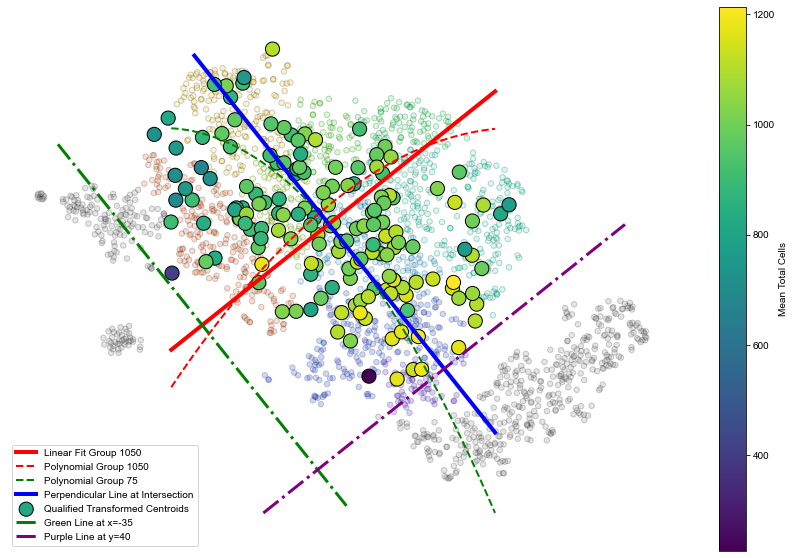

In [43]:
#FILTER OUT FAILURE MODE CLUSTERS

# Load the data files
df_labels = pd.read_excel('point_labels.xlsx')
poly_coefficients_starting = pd.read_csv('polynomial_coefficients.csv')
poly_coefficients_ending = pd.read_csv('polynomial_coefficients_ending.csv')

# Assume x and y are defined as the t-SNE results of the data points
x = tsne_results[:, 0]  # t-SNE values for x
y = tsne_results[:, 1]  # t-SNE values for y

# Calculate centroids based on drug conditions
tsne_df_copy = tsne_df.copy()
tsne_df_copy['Drug'] = tsne_df_copy.index.to_series().str.replace(r'_\d+', '', regex=True)
centroids = tsne_df_copy.groupby('Drug').agg({
    'tsne_1': 'mean',
    'tsne_2': 'mean',
    'total cells': 'mean'
}).reset_index()

# Step 1: Plotting scatter plot with the linear fit for Group 1050
plt.figure(figsize=(15, 10))
cmap = plt.cm.gist_rainbow
norm = mcolors.Normalize(vmin=np.min(df_labels['Point_Label']), vmax=np.max(df_labels['Point_Label']))
colors = cmap(norm(df_labels['Point_Label'].values))
transparency_mask = np.isin(df_labels['Point_Label'], [1, 11, 12])
colors[transparency_mask] = np.array([0.5, 0.5, 0.5, 0.1])
plt.scatter(x, y, color=colors, edgecolors='black', s=30, alpha=0.2)

# Extracting the relevant polynomials for group_number 1050 and 75
starting_1050 = poly_coefficients_starting[poly_coefficients_starting['Group'] == 1050]
ending_75 = poly_coefficients_ending[poly_coefficients_ending['Group'] == 75]

# Coefficients for the polynomials
coeffs_1050 = [starting_1050.iloc[0]['Coefficient_0'], starting_1050.iloc[0]['Coefficient_1'], starting_1050.iloc[0]['Coefficient_2']]
coeffs_75 = [ending_75.iloc[0][f'Coefficient_{i}'] for i in range(3)]
p_1050 = Polynomial(coeffs_1050)
p_75 = Polynomial(coeffs_75)

# Fit a linear line to the group 1050 polynomial
x_fit = np.linspace(-40, 30, 1000)  # Adjust range as needed
y_1050 = p_1050(x_fit)
linear_fit_1050 = np.polyfit(x_fit, y_1050, 1)
linear_1050 = np.poly1d(linear_fit_1050)

# Plot the linear line for Group 1050
plt.plot(x_fit, linear_1050(x_fit), color='red', linestyle='-', linewidth=4, label='Linear Fit Group 1050')

# Plot the original polynomial line for Group 1050 as a dashed line
plt.plot(x_fit, y_1050, color='red', linestyle='--', linewidth=2, label='Polynomial Group 1050')

# Finding the intersection between Group 1050 linear line and Group 75 polynomial
y_75 = p_75(x_fit)
intersection_x = x_fit[np.argmin(np.abs(linear_1050(x_fit) - y_75))]
intersection_y = linear_1050(intersection_x)

# Plot the original polynomial line for Group 75 as a dashed line
plt.plot(x_fit, y_75, color='green', linestyle='--', linewidth=2, label='Polynomial Group 75')

# Create a perpendicular line to the linear fit at the intersection point
slope_1050 = linear_fit_1050[0]
slope_perpendicular = -1 / slope_1050
intercept_perpendicular = intersection_y - slope_perpendicular * intersection_x
perpendicular_line = np.poly1d([slope_perpendicular, intercept_perpendicular])

# Plot the perpendicular line
extended_x_fit = np.linspace(-35, 30, 1000)  # This controls the extent of the perpendicular line
plt.plot(extended_x_fit, perpendicular_line(extended_x_fit), color='blue', linestyle='-', linewidth=4, label='Perpendicular Line at Intersection')

# Define unit vectors for the new axes
vector_x_axis = np.array([1, slope_1050]) / np.sqrt(1 + slope_1050**2)  # Parallel to the red line (linear fit line)
vector_y_axis = np.array([1, slope_perpendicular]) / np.sqrt(1 + slope_perpendicular**2)  # Parallel to the blue line (perpendicular line)

# Function to calculate new coordinates in the transformed system
def transform_to_new_coords(x_point, y_point):
    # Calculate the relative position vector from the intersection point
    relative_position = np.array([x_point - intersection_x, y_point - intersection_y])
    # Project the relative position onto the new axes
    new_x = np.dot(relative_position, vector_x_axis)
    new_y = np.dot(relative_position, vector_y_axis)
    return new_x, new_y

# Apply transformation to the centroids
centroids['transformed_tsne_1'], centroids['transformed_tsne_2'] = zip(*centroids.apply(
    lambda row: transform_to_new_coords(row['tsne_1'], row['tsne_2']), axis=1))

# Filter centroids based on the transformed coordinates
filtered_centroids = centroids[(centroids['transformed_tsne_2'] <= 40) & (centroids['transformed_tsne_1'] >= -35)]

# Plot the qualified centroids
plt.scatter(
    intersection_x + filtered_centroids['transformed_tsne_1'] * vector_x_axis[0] + filtered_centroids['transformed_tsne_2'] * vector_y_axis[0],
    intersection_y + filtered_centroids['transformed_tsne_1'] * vector_x_axis[1] + filtered_centroids['transformed_tsne_2'] * vector_y_axis[1],
    c=filtered_centroids['total cells'], cmap='viridis', s=200, edgecolors='black', label='Qualified Transformed Centroids'
)

# Function to plot parallel lines relative to the new coordinate system
def plot_parallel_lines():
    # Define a vertical line (relative to the new coordinate system) at x = -35
    green_x = -35
    green_start = (intersection_x + green_x * vector_x_axis[0] - 50 * vector_y_axis[0], 
                   intersection_y + green_x * vector_x_axis[1] - 50 * vector_y_axis[1])
    green_end = (intersection_x + green_x * vector_x_axis[0] + 50 * vector_y_axis[0], 
                 intersection_y + green_x * vector_x_axis[1] + 50 * vector_y_axis[1])

    # Define a horizontal line (relative to the new coordinate system) at y = 40
    purple_y = 40
    purple_start = (intersection_x + purple_y * vector_y_axis[0] - 50 * vector_x_axis[0], 
                    intersection_y + purple_y * vector_y_axis[1] - 50 * vector_x_axis[1])
    purple_end = (intersection_x + purple_y * vector_y_axis[0] + 50 * vector_x_axis[0], 
                  intersection_y + purple_y * vector_y_axis[1] + 50 * vector_x_axis[1])

    # Plot the green line equally forward and backward
    plt.plot([green_start[0], green_end[0]], [green_start[1], green_end[1]], 
             color='green', linestyle='-.', linewidth=3, label='Green Line at x=-35')

    # Plot the purple line equally forward and backward
    plt.plot([purple_start[0], purple_end[0]], [purple_start[1], purple_end[1]], 
             color='purple', linestyle='-.', linewidth=3, label='Purple Line at y=40')

plot_parallel_lines()

# Format plot and aspect ratio
plt.gca().set_aspect('equal', adjustable='datalim')
plt.gca().axis('off')
plt.colorbar(label='Mean Total Cells')
plt.legend()

# Save the plot
plt.savefig('Qualified_Transformed_Centroids.png', bbox_inches='tight', dpi=300)
plt.show()

In [44]:
#PRINT LOCATIONS OF CLUSTER CENTROIDS

# Step 1: Add 'cluster' and 'target' columns from tsne_df to centroids
centroids = centroids.merge(tsne_df[['cluster', 'target']], left_on='Drug', right_index=True, how='left')

# Step 2: Sort centroids by 'transformed_tsne_1' in descending order
centroids_sorted = centroids.sort_values(by='transformed_tsne_1', ascending=False)

# Step 3: Export the sorted table to Excel
centroids_sorted.to_excel('sorted_centroids_with_cluster_and_target.xlsx', index=False)

# Display the sorted table
print(centroids_sorted[['Drug', 'transformed_tsne_1', 'transformed_tsne_2', 'total cells', 'cluster', 'target']])

                                                  Drug  transformed_tsne_1  \
108                                               NG25           38.752445   
202                                           YH239-EE           38.249090   
14                                       Alantolactone           33.068879   
141                                Quercetin Dihydrate           31.135144   
1                          2',5'-Dihydroxyacetophenone           30.425188   
162                                             SU5402           30.408472   
43                                           ERK5-IN-2           29.064865   
159                                           SP600125           28.693666   
180                                 Tacrolimus (FK506)           27.616837   
25                                          CCG-222740           26.033673   
64                                         Halcinonide           24.689541   
70                                                IQ-1          